<h1 style="text-align: center;">High-frequency time series modelling</h1>

## 1. Exploratory data analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df_csv = pd.read_csv('out22.csv')
print(df_csv.head())

   day      tick  logprice
0    1  0.002564  3.646494
1    1  0.002607  3.647276
2    1  0.002650  3.647406
3    1  0.002692  3.646494
4    1  0.002821  3.646233


In [6]:
print(len(df_csv['day'].unique()))

754


We study the price trajectory over a period of 754 days.

C:\Users\Manuel\AppData\Local\Temp\ipykernel_13080\3264943605.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('day', group_keys=False).apply(normalize_tick)


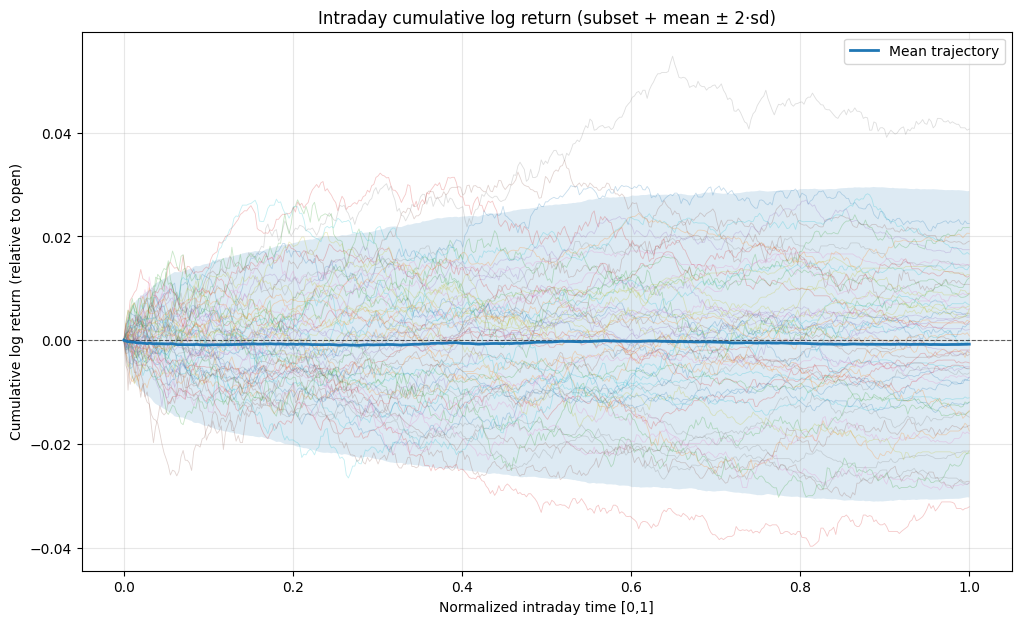

In [8]:
# 1) Cumulative log-price relative to the day’s first tick (= ‘cumulative log return’)
df = df_csv.copy()
df = df.sort_values(['day', 'tick'])
df['adj_logprice'] = df.groupby('day')['logprice'].transform(lambda x: x - x.iloc[0])

# 2) Normalize time per day on the interval [0, 1]
def normalize_tick(g):
    n = len(g)
    # Normalized time [0,1]
    t_norm = np.linspace(0, 1, n)
    g = g.copy()
    g['t_norm'] = t_norm
    return g

df = df.groupby('day', group_keys=False).apply(normalize_tick)

# 3) Common grid for aggregation
T = np.linspace(0, 1, 400)   # Smoothed grid
days = df['day'].unique()

# Interpolate each day on the common grid
interp_vals = []
for d in days:
    gd = df[df['day'] == d]
    # Safety: at least 2 points are needed for interpolation
    if len(gd) >= 2:
        vals = np.interp(T, gd['t_norm'].values, gd['adj_logprice'].values)
        interp_vals.append(vals)

M = np.vstack(interp_vals)   # Shape = (n_days, len(T))

mean_curve = M.mean(axis=0)
sd_curve   = M.std(axis=0)   # Pointwise band (standard deviation, not standard error)

# 4) Plot a subsample of days in the background
plt.figure(figsize=(12, 7))
n_show = min(60, M.shape[0])   # Ex. 60 days
# n_show = M.shape[0]
idx = np.random.choice(M.shape[0], n_show, replace=False)

for i in idx:
    plt.plot(T, M[i], lw=0.6, alpha=0.25)

# 5) Mean + band ±2·sd
plt.fill_between(T, mean_curve - 2*sd_curve, mean_curve + 2*sd_curve, alpha=0.15, linewidth=0)   # Band
plt.plot(T, mean_curve, lw=2, label='Mean trajectory', zorder=3)

plt.axhline(0, color='k', lw=0.8, ls='--', alpha=0.6)
plt.xlabel('Normalized intraday time [0,1]')
plt.ylabel('Cumulative log return (relative to open)')
plt.title('Intraday cumulative log return (subset + mean ± 2·sd)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

We loop over the days.
gd: sub-dataframe for day d.
We require at least 2 points for linear interpolation to make sense. np.interp(T, x, y):

- x = gd['t_norm'] (normalized time increasing on [0,1])
- y = gd['adj_logprice'] (cumulative log return centered at the opening)

returns y resampled at the times T by linear interpolation.
vals is therefore a vector of length 400: the trajectory for day d resampled on the common grid.
We stack everything into interp_vals.

M[i, :] = trajectory of the i-th day (length 400).
Dimensions: (number_of_days, 400).
This allows you to compute pointwise statistics (column by column = same intraday time on the grid).

mean_curve[t] = average of the days at time T[t].
sd_curve[t] = standard deviation of the days at the same time (dispersion of the curves, not the standard error of the mean).
If you wanted a confidence interval for the mean, you would use sd_curve / sqrt(n_days).

Plotting all days makes the figure unreadable.
We randomly select n_show days to give visual context without saturating the screen.
lw=0.6, alpha=0.25: thin and transparent lines so they don’t overshadow the mean. Then we add:
- the mean: plt.plot(T, mean_curve, lw=2),
- a variability band: plt.fill_between(T, mean_curve - 2*sd_curve, mean_curve + 2*sd_curve).

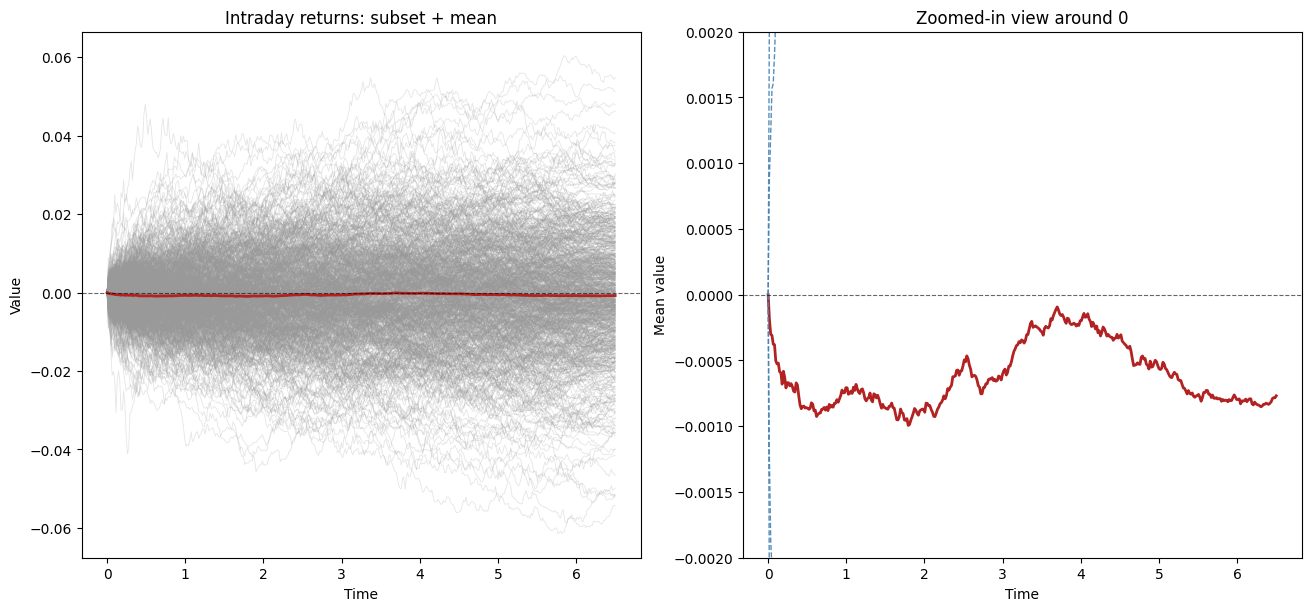

In [14]:
# Stats pointwise
mean_curve = M.mean(axis=0)
q10 = np.percentile(M, 10, axis=0)
q25 = np.percentile(M, 25, axis=0)
q75 = np.percentile(M, 75, axis=0)
q90 = np.percentile(M, 90, axis=0)

# Rescaling time axis in "hours"
H = 6.5   # ~6h30 open
time_axis = T * H

# Two-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), constrained_layout=True)

# (Left) global view: subsample of days + mean
# n_show = min(60, M.shape[0])
n_show = M.shape[0]
idx = np.random.choice(M.shape[0], n_show, replace=False)

for i in idx:
    ax1.plot(time_axis, M[i], color='0.6', lw=0.6, alpha=0.25)

ax1.plot(time_axis, mean_curve, color='firebrick', lw=2)
ax1.axhline(0, color='k', ls='--', lw=0.8, alpha=0.6)

ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Intraday returns: subset + mean')

# (Right) zoomed view: mean + bands (quantiles)
ax2.plot(time_axis, mean_curve, color='firebrick', lw=2, label='mean')

# Bands/markers in dashed lines (quantiles)
ax2.plot(time_axis, q10, ls='--', lw=1, color='steelblue', alpha=0.9)
ax2.plot(time_axis, q25, ls='--', lw=1, color='steelblue', alpha=0.9)
ax2.plot(time_axis, q75, ls='--', lw=1, color='steelblue', alpha=0.9)
ax2.plot(time_axis, q90, ls='--', lw=1, color='steelblue', alpha=0.9)

ax2.axhline(0, color='k', ls='--', lw=0.8, alpha=0.6)
ax2.set_xlabel('Time')
ax2.set_ylabel('Mean value')
ax2.set_title('Zoomed-in view around 0')

# Zoom
y_zoom = 0.002                       
ax2.set_ylim(-y_zoom, y_zoom)

# plt.savefig("expl.png", dpi=300, bbox_inches='tight')
plt.show()

We can see that the shape of the mean μ̂(t) is not strictly flat. The variance is not constant, so the first components of the FPCA will be able to capture information about the variations at the beginning, at the end, and around time ≈ 4.

## 2. Functional data analysis for intraday cumulative log returns

### 2.1. FPCA

In [20]:
df_csv['adjusted_logprice'] = df_csv.groupby('day')['logprice'].transform(lambda x: x - x.iloc[0])
df2 = df_csv.sort_values(['day', 'tick']).copy()
mask = df2['day'].between(0, 377)
df = df2.loc[mask].copy()
df = df.groupby('day', group_keys=False).apply(normalize_tick)

T = np.linspace(0, 1, 400)          
days = df['day'].unique()

interp_vals = []
for d in days:
    gd = df[df['day'] == d]
    if len(gd) >= 2:
        vals = np.interp(T, gd['t_norm'].values, gd['adjusted_logprice'].values)
        interp_vals.append(vals)

M = np.vstack(interp_vals)   # Shape = (n_days, len(T)) = (377, 400)
mean_curve = M.mean(axis=0)

# Center all curves on the pointwise mean
M_centered = M - mean_curve   # Broadcast (n_days, len(T)) - (len(T),)

# Number of days and points
n_days, m_points = M.shape

# Empirical covariance matrix between times (ticks)
C_hat = (M_centered.T @ M_centered) / (n_days - 1)   # Shape (m_points, m_points)

print(C_hat.shape)
print(C_hat.trace())

C:\Users\Manuel\AppData\Local\Temp\ipykernel_13080\1557217939.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('day', group_keys=False).apply(normalize_tick)


(400, 400)
0.07825210183886083


The sum of the eigenvalues of the estimator of the variance–covariance matrix is 0.0782...

In [22]:
v = np.ones(m_points)
W = np.diag(v)
print(W.shape)

(400, 400)


In [23]:
# Uniform weighting if the grid T is regular
delta_t = 1 / (m_points - 1)

# Weighted diagonalization (integral approximation)
eigvals, eigvecs = np.linalg.eigh(delta_t * C_hat)

# Descending sort
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Normalisation (just to be sure)
eigvecs = eigvecs / np.sqrt(np.sum(eigvecs**2 * delta_t, axis=0))

print(eigvals.sum())
print(eigvals.sum()*399)   # We indeed recover the trace of C when removing the weighting

0.00019612055598711983
0.0782521018388608


How many eigenvectors are needed to explain 90% of the variance?

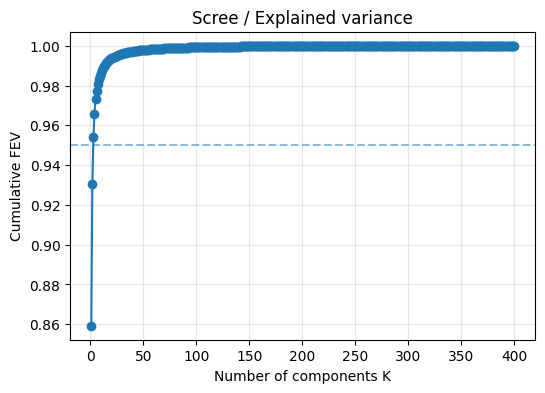

Chosen K: 3


In [25]:
# Cumulative fraction of explained variance
fve = np.cumsum(eigvals) / np.sum(eigvals)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigvals)+1), fve, marker='o')
plt.axhline(0.95, ls='--', alpha=0.5)
plt.xlabel('Number of components K'); plt.ylabel('Cumulative FEV')
plt.title('Scree / Explained variance'); plt.grid(True, alpha=0.3)
# plt.savefig("var.png", dpi=300, bbox_inches='tight')
plt.show()

# Choose K (e.g., the first K that reaches 90% or 95%)
K = int(np.searchsorted(fve, 0.95) + 1)
print("Chosen K:", K)

We reach 90% of explained variance with only the first 2 vectors, and more than 95% with the first 3.

Cumulative variance explained by the first 3 eigenvalues: 95.42%
Norms of the functions: [1.0, 1.0, 1.0]


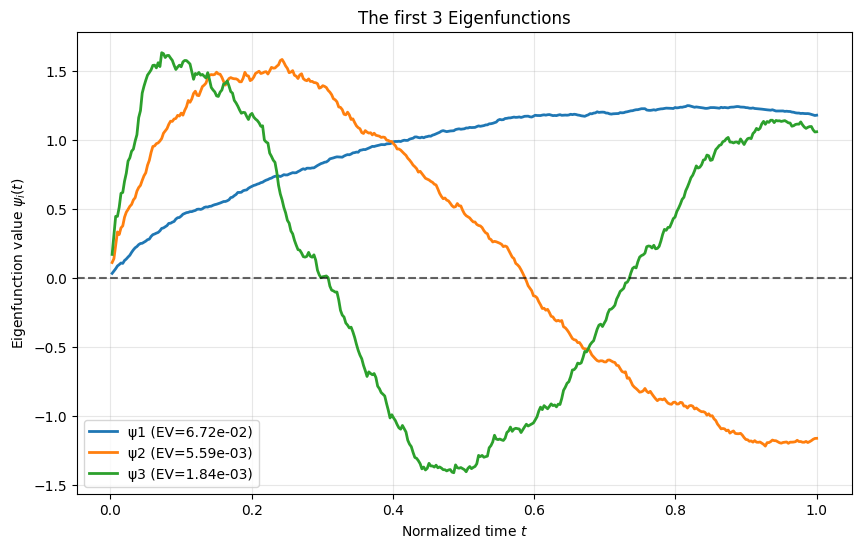

In [27]:
def plot_functional_pca(M_centered, T, p=3):
    """
    Compute and plot the first p eigenfunctions for FPCA

    Args:
        M_centered (np.ndarray): Matrix of centered curves (n_days, m_points).
        T (np.ndarray): Time grid used for interpolation (m_points).
        p (int): Number of eigenfunctions to compute and plot (p >= 1).
    """

    # Remove the first column (t = 0) for stability
    M_use = M_centered[:, 1:]
    T_use = T[1:]
    n_days, m_points = M_use.shape

    # Compute the empirical covariance matrix
    C_hat = (M_use.T @ M_use) / (n_days - 1)   # Manually computed matrix
    # C_hat = np.cov(M_use, rowvar=False)   # rowvar=False specifies that the variables are the columns (time)

    # Define the time spacing for L2 normalization and the scaling of the eigenvalues 
    delta_t = 1.0 / (m_points - 1)

    # Spectral decomposition (Eigenvalues and Eigenvectors)
    # The argument delta_t is applied here to scale the eigenvalues
    eigvals, eigvecs = np.linalg.eigh(C_hat)   # C_hat is already divided by n_days - 1

    # Sort by decreasing eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Functional L2 normalisation: ||ψ||_L2^2 = ∑ ψ^2 Δt = 1
    l2_norms = np.sqrt(np.sum(eigvecs**2, axis=0) * delta_t)
    eigvecs = eigvecs / l2_norms

    print(f"Cumulative variance explained by the first {p} eigenvalues: {eigvals[:p].sum() / eigvals.sum() * 100:.2f}%")

    # Display of the L2 normalization checks
    print(f"Norms of the functions: {[round(np.sum(eigvecs[:, i]**2) * delta_t, 3) for i in range(min(p, eigvecs.shape[1]))]}")

    plt.figure(figsize=(10, 6))

    for i in range(p):
        if i >= eigvecs.shape[1]:
            break   # Do not exceed the number of available eigenfunctions

        psi = eigvecs[:, i]

        # Flip the sign if the mean is negative (for better visual interpretation)
        if psi.mean() < 0:
            psi = -psi

        # The eigenvalue is the variance explained by this eigenfunction
        label = f'ψ{i+1} (EV={eigvals[i]:.2e})'
        plt.plot(T_use, psi, lw=2, label=label)

    plt.axhline(0, ls='--', color='k', alpha=0.6)
    plt.xlabel('Normalized time $t$'); plt.ylabel('Eigenfunction value $\\psi_i(t)$')
    plt.title(f'The first {p} Eigenfunctions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    # plt.savefig("eigen.png", dpi=300, bbox_inches='tight')
    plt.show()

    return eigvals, eigvecs, T_use

eigvals, eigvecs, T_use = plot_functional_pca(M_centered, T, p=3)

Interpretation:
- First: global trend (blue).
- Second: represents the difference between the first part of the day and the end (orange).
- Third: represents the similarity between the morning and the evening, and the contrast with midday (green).

The first row/column of the covariance is zero ⇒ the matrix is singular and the spectral problem admits arbitrary eigenvectors (e.g. e₁), which produces a “pseudo-Dirac” in the plot of ψ₁.

Let’s compute the scores, that is, the coefficients by which to multiply the eigenfunctions, for each different day.

In [31]:
M_use = M_centered[:, 1:]
scores = M_use @ (eigvecs[:, :K] * delta_t)   # Shape = (n_days, K)
print(scores.shape)   # Size (377,3): 377 days and 3 K
ksi1 = scores[:, 0]
ksi2 = scores[:, 1]
ksi3 = scores[:, 2]

(377, 3)


### 2.2. WN check 

We check whether the ξ coefficients can be considered white noise and/or normal.

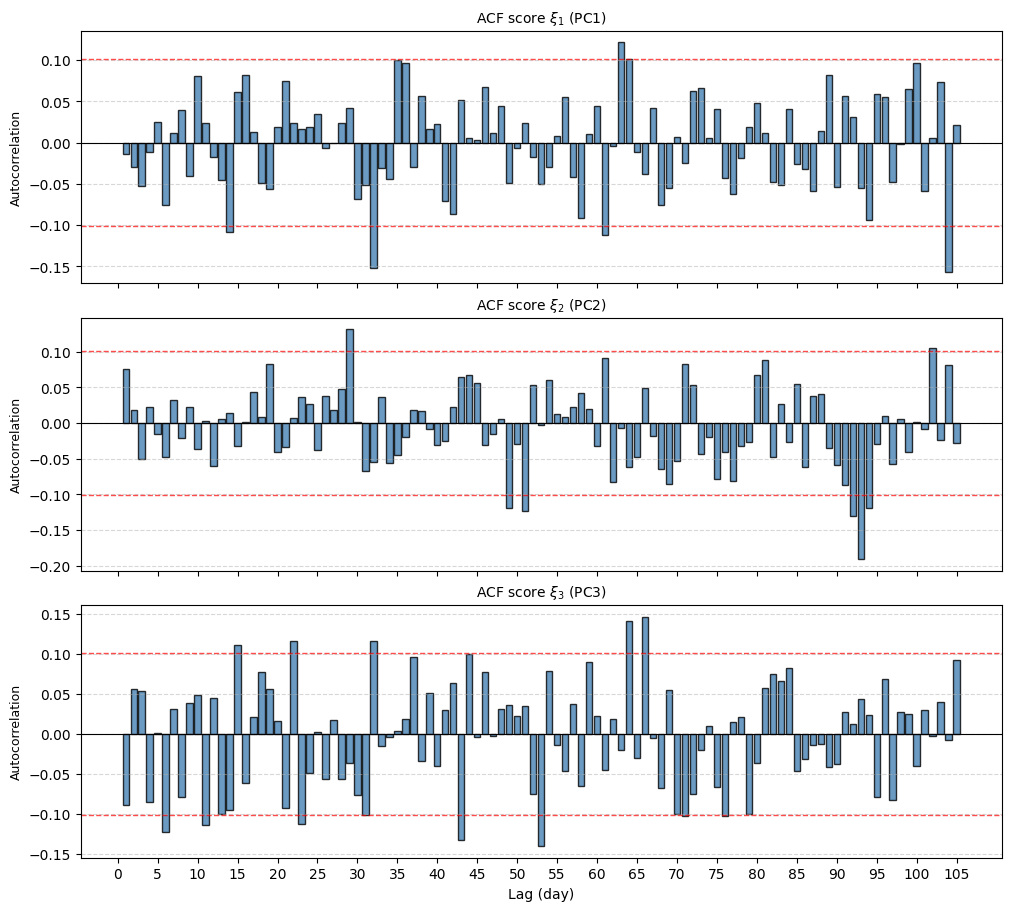

In [34]:
def compute_acf(x, max_lag):
    """
    Compute the sample ACF up to max_lag (including lag 0) without external stats helpers.
    x: 1D array-like
    Returns: np.ndarray of length max_lag+1 with rho[0] = 1
    """
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    n = x.shape[0]
    if n < max_lag + 1:
        raise ValueError("Series is too short for the requested max_lag.")

    # Variance proxy (autocovariance at lag 0)
    gamma0 = np.dot(x, x) / n
    if gamma0 == 0:
        # Constant series: undefined ACF beyond lag 0; return zeros except rho[0]=1
        rho = np.zeros(max_lag + 1)
        rho[0] = 1.0
        return rho

    rho = np.empty(max_lag + 1, dtype=float)
    rho[0] = 1.0

    for k in range(1, max_lag + 1):
        # gamma_k = sum_{t=k..n-1} x_t * x_{t-k} / denom
        num = np.dot(x[k:], x[:-k])
        denom = n - k
        gamma_k = num / denom
        rho[k] = gamma_k / gamma0

    return rho

def plot_multi_acf(scores_matrix, K=3, max_lag=30):
    """
    Plot the ACF of the first K columns (scores) in stacked subplots.
    """
    n_days = scores_matrix.shape[0]

    # Create a figure with K rows and 1 column
    fig, axes = plt.subplots(K, 1, figsize=(10, 3 * K), constrained_layout=True)

    # Compute the confidence band
    conf = 1.96 / np.sqrt(n_days)
    lags = np.arange(1, max_lag + 1)

    for i in range(K):
        ax = axes[i]
        xi_k = scores_matrix[:, i]   # Selection of score xi_k
        rho = compute_acf(xi_k, max_lag=max_lag)

        # Title
        ax.set_title(f"ACF score $\\xi_{i+1}$ (PC{i+1})", fontsize=10)

        # Confidence limit
        ax.axhline(0.0, color='k', lw=0.8)
        ax.axhline(conf, linestyle="--", color='r', alpha=0.7, lw=1)
        ax.axhline(-conf, linestyle="--", color='r', alpha=0.7, lw=1)

        # ACF bars
        ax.bar(lags, rho[1:max_lag + 1], width=0.8, align="center", color='steelblue', edgecolor='k', alpha=0.8)

        # Labels
        ax.set_ylabel("Autocorrelation", fontsize=9)
        ax.set_xticks(np.arange(0, max_lag + 1, 5))   # Simplify X axis
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # X labels only on the last subplot
        if i == K - 1:
            ax.set_xlabel("Lag (day)", fontsize=10)
        else:
            ax.tick_params(labelbottom=False)
            
    plt.show()

# Execution
K = 3
max_lag = 105
plot_multi_acf(scores, K=K, max_lag=max_lag)

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

alpha = 0.05
max_lag = 105

for k in range(0, 3):
    x = scores[:, k]   # Scores ξ_{n,k} on the train

    lb_res = acorr_ljungbox(x, lags=[max_lag], return_df=True)

    stat = lb_res['lb_stat'].iloc[0]
    pval = lb_res['lb_pvalue'].iloc[0]

    decision = "Reject H0 " if pval < alpha else "Fail to reject H0"
    print(f"PC{k+1}: Ljung–Box (lag={max_lag}) stat={stat:.3f}, p-value={pval:.4f} -> {decision}")

PC1: Ljung–Box (lag=105) stat=104.739, p-value=0.4888 -> Fail to reject H0
PC2: Ljung–Box (lag=105) stat=101.813, p-value=0.5699 -> Fail to reject H0
PC3: Ljung–Box (lag=105) stat=150.920, p-value=0.0022 -> Reject H0 


PC1:
All bars are small, very rarely slightly above the confidence bands.
No clear pattern (no slow decay, no systematic alternation).
➜ Visually consistent with white noise, exactly like the Ljung–Box result (p-value >> 0.05).

PC2:
Same picture: small correlations fluctuating around 0, a few isolated exceedances.
➜ Again, white-noise-like behaviour; Ljung–Box does not reject → consistent.

PC3:
A few more bars close to the bands, some exceedances, but still very “noisy”.
➜ This matches Ljung–Box: p-value ≈ 0.0022 → a slight dependence is detected.

We therefore have a clear confirmation from the Ljung–Box test regarding the nature of the ξₙₖ series.  
This means we can proceed to predict these three time series: using a simple model for ξ₁ and ξ₂ (white-noise-compatible), and a slightly more elaborate model for ξ₃, which is not considered white noise.

### 2.3. Normality check

Jarque–Bera test to check whether the ξₙₖ are normally distributed.

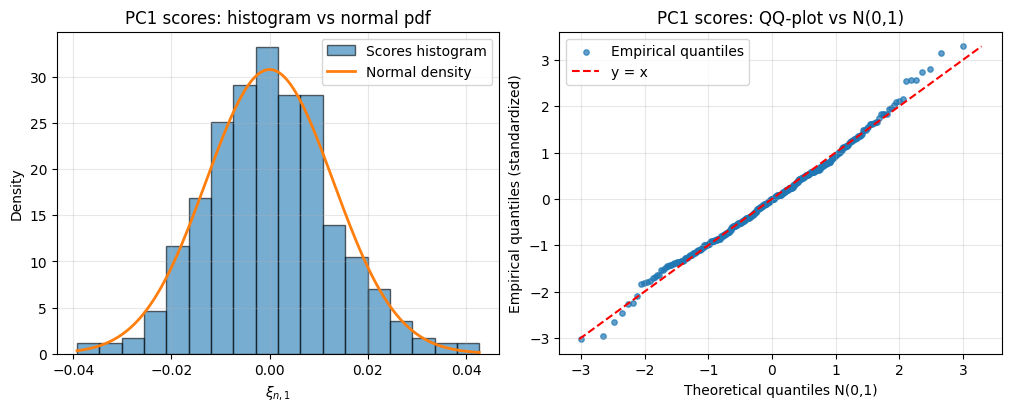

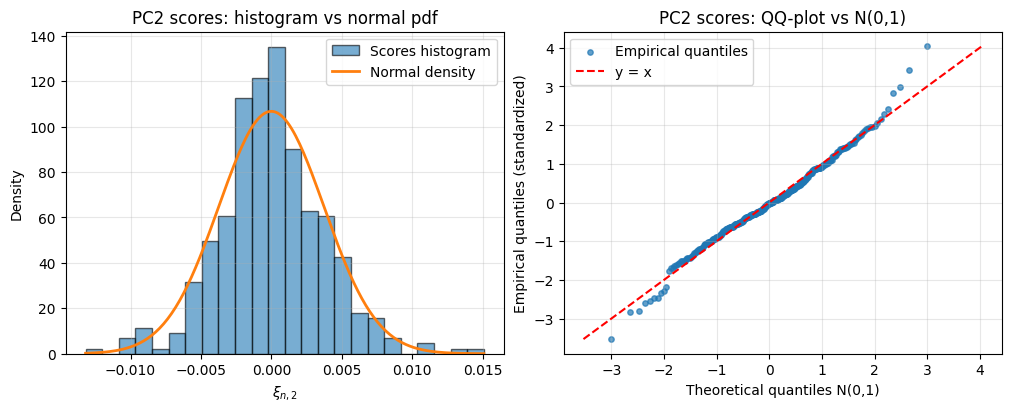

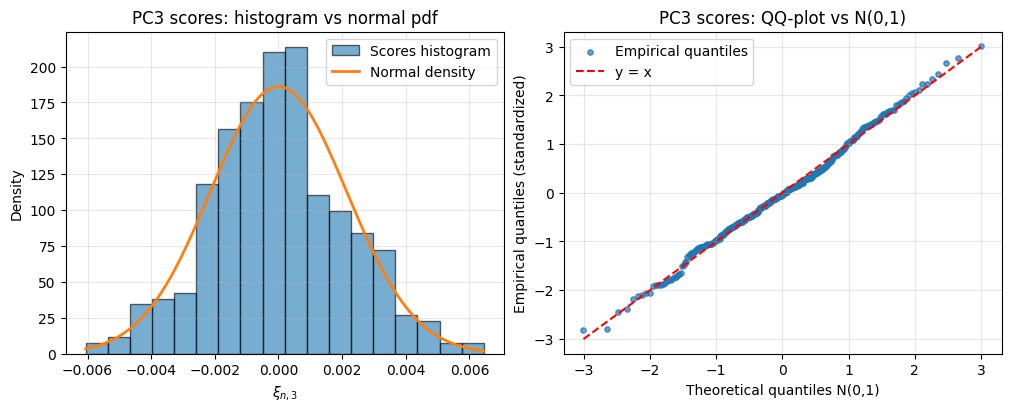

In [39]:
from scipy.stats import norm  

K_plot = 3 

for k in range(K_plot):
    x = scores[:, k]
    n = x.shape[0]

    # Empirical mean and std of the scores for the normal approximation
    mu = x.mean()
    sigma = x.std(ddof=1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    # (Left) Histogram + normal density
    ax = axes[0]

    # Histogram of scores (density=True for a pdf)
    ax.hist(x, bins="auto", density=True, alpha=0.6, edgecolor="k", label="Scores histogram")

    # Normal density with same mean and std
    grid = np.linspace(x.min(), x.max(), 200)
    pdf = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((grid - mu) / sigma) ** 2)
    ax.plot(grid, pdf, lw=2, label="Normal density")

    ax.set_title(f"PC{k+1} scores: histogram vs normal pdf")
    ax.set_xlabel(r"$\xi_{n," + str(k+1) + "}$")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # (Right) QQ-plot vs normal
    ax = axes[1]

    # Sort standardized scores
    x_std = (x - mu) / sigma
    x_std_sorted = np.sort(x_std)

    # Theoretical quantiles of standard normal
    probs = (np.arange(1, n + 1) - 0.5) / n
    theo_q = norm.ppf(probs)

    ax.scatter(theo_q, x_std_sorted, s=15, alpha=0.7, label="Empirical quantiles")

    # Reference line y = x
    q_min = min(theo_q.min(), x_std_sorted.min())
    q_max = max(theo_q.max(), x_std_sorted.max())
    ax.plot([q_min, q_max], [q_min, q_max], "r--", lw=1.5, label="y = x")

    ax.set_title(f"PC{k+1} scores: QQ-plot vs N(0,1)")
    ax.set_xlabel("Theoretical quantiles N(0,1)")
    ax.set_ylabel("Empirical quantiles (standardized)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # plt.savefig("normS.png", dpi=300, bbox_inches='tight')
    plt.show()

In [40]:
from scipy.stats import jarque_bera

# Scores: shape (n_days, K)
alpha = 0.05   # Significance level

jb_stats = []
for k in range(scores.shape[1]):
    stat, p = jarque_bera(scores[:, k])
    jb_stats.append((k+1, stat, p, "Reject H0 (non-normal)" if p < alpha else "Fail to reject H0 (normal)"))

print("Jarque–Bera normality test on FPCA scores (per component)")
print("k | JB stat | p-value | Decision (alpha=0.05)")
for k, stat, p, dec in jb_stats:
    print(f"{k:>1} | {stat:8.4f} | {p:8.4g} | {dec}")

Jarque–Bera normality test on FPCA scores (per component)
k | JB stat | p-value | Decision (alpha=0.05)
1 |   6.0328 |  0.04898 | Reject H0 (non-normal)
2 |  25.3019 | 3.205e-06 | Reject H0 (non-normal)
3 |   1.0400 |   0.5945 | Fail to reject H0 (normal)


### 2.4. Noise variance

In [42]:
def estimate_noise_variance_rv(M_use, scores, eigvecs, delta_t, p):
    """
    Estimate the variance of the residual noise (eta^2) using the Realized Volatility (RV)
    of the residuals, operating on the 399 points (t > 0).

    Args:
        M_use (np.ndarray): Matrix of centered curves without the t=0 point. (N_days, 399)
        scores (np.ndarray): Matrix of scores (N_days, K)
        eigvecs (np.ndarray): Matrix of eigenfunctions (399, 399)
        delta_t (float): Time interval (1/399)
        p (int): Number of components used for the reconstruction.
    """

    # 1) Reconstruct the explained component (M_hat_centered)
    # We use M_use, so M_use has shape (N_days, 399)
    # The correct estimator is: scores @ (eigvecs.T / delta_t)
    M_hat_centered = scores[:, :p] @ (eigvecs[:, :p].T / delta_t)

    # 2) Compute the residual (noise)
    M_residu = M_use - M_hat_centered

    # 3) Compute the Realized Volatility (RV) of the residuals
    # np.diff() operates on the 399 points -> 398 returns
    Residual_Returns = np.diff(M_residu, axis=1)
    RV_epsilon_n = np.sum(Residual_Returns**2, axis=1)

    # 4) Compute the mean residual RV over all days
    mean_RV_epsilon = np.mean(RV_epsilon_n)

    # 5. Estimate the noise variance eta^2 using the proposed formula:
    # The estimator is: (Mean(RV_epsilon) * delta_t) / 2; mean / n
    eta2_hat = (mean_RV_epsilon * delta_t) / 2

    print(f"Variance of the noise estimated by RV of the residuals (p={p}): {eta2_hat:.6e}")
    return eta2_hat

eta2_hat = estimate_noise_variance_rv(M_use, scores, eigvecs, delta_t, p=3)   # Lower than the signal variance 0.078 (trace)

Variance of the noise estimated by RV of the residuals (p=3): 1.215453e-03


### 2.5. Quality of the fit as a function of p

In [45]:
np.var(scores[:,0], ddof=1)
np.unique(scores[:,0]).size

377

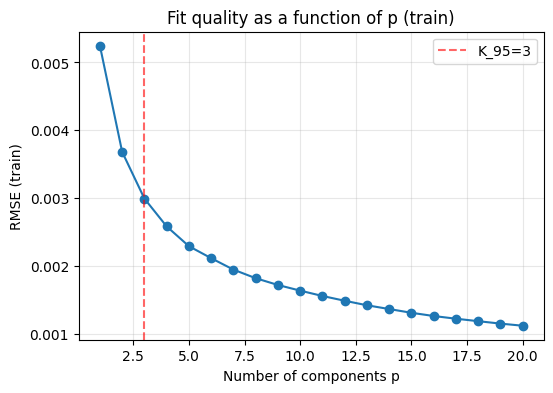

In [46]:
# RMSE on the training sample as a function of p

# 1) Use the same grid as in the FPCA
M_use = M_centered[:, 1:]   # (n_days, m_points-1)
n_days, m_points = M_use.shape
delta_t = 1.0 / (m_points - 1)   # Same Δt as above

# 2) Scores for ALL components (not only up to K_95)
# ξ_{n,k} = ⟨X_n, ψ_k⟩ ≈ Σ_j X_n(t_j) ψ_k(t_j) Δt
scores_full = M_use @ (eigvecs * delta_t)   # Shape = (n_days, m_points-1)

# 3) RMSE(p) on the training sample
P_max = 20   # or len(eigvals) if you want all of them
rmse_list = []

for p in range(1, P_max + 1):
    # reconstruction using the first p components:
    # X̂_n(t_j) = Σ_{k=1}^p ξ_{n,k} ψ_k(t_j)
    M_hat_p = scores_full[:, :p] @ eigvecs[:, :p].T   # (n_days, m_points-1)

    # Mean squared error over all days and all time points
    mse_p = np.mean((M_use - M_hat_p)**2)
    rmse_p = np.sqrt(mse_p)
    rmse_list.append(rmse_p)

# 4) Plot RMSE(p)
plt.figure(figsize=(6,4))
plt.plot(range(1, P_max + 1), rmse_list, marker='o')
plt.xlabel("Number of components p")
plt.ylabel("RMSE (train)")
plt.title("Fit quality as a function of p (train)")
plt.grid(True, alpha=0.3)

# Option: mark K that reaches 95% explained variance
K_95 = int(np.searchsorted(fve, 0.95) + 1)
plt.axvline(K_95, ls='--', color='r', alpha=0.6, label=f"K_95={K_95}")
plt.legend()

# plt.savefig("rmseS.png", dpi=300, bbox_inches='tight')
plt.show()

We can clearly see that, using the elbow method, FPCA is sufficiently effective to explain the whole dataset with only 3 components. We have shown that:
p = 3 is enough for >95% FVE → the intrinsic dimensionality is low,
the ψₖ generalize to unseen days → the structure is stable over time.

Therefore:
the ψₖ can be used for prediction,
the ξₙₖ faithfully summarize the intraday curves.
This is the empirical validation of the functional model.
Without this step, predicting ξₙₖ would make no sense.

Since p = 3 is sufficient, we will model only 3 time series.
Instead of predicting 400-dimensional curves, we now predict:
the time series of scores ξₙ,1,
the time series of scores ξₙ,2,
the time series of scores ξₙ,3.
Thus, we fit an ARIMA model for the third one, and for the white-noise ξ we predict using their mean.

### 2.6. Prediction performance

In [49]:
# All days of the csv
all_days = np.sort(df_csv['day'].unique())

# Split (50% train / 50% test)
n_total = len(all_days)
n_train = int(0.5 * n_total)

train_days = all_days[:n_train]
test_days  = all_days[n_train:]

print("n_train:", len(train_days), "n_test:", len(test_days))

n_train: 377 n_test: 377


In [50]:
def build_M_for_days(df_source, days_subset, T):
    """
    Build the matrix M (intraday curves sampled on a T grid) for specified days.
    """
    df = df_source.copy()
    df = df.sort_values(['day', 'tick'])

    df['adj_logprice'] = df.groupby('day')['logprice'].transform(lambda x: x - x.iloc[0])

    def normalize_tick(g):
        n = len(g)
        t_norm = np.linspace(0, 1, n)
        g = g.copy()
        g['t_norm'] = t_norm
        return g

    df = df.groupby('day', group_keys=False).apply(normalize_tick)
    df = df[df['day'].isin(days_subset)]

    interp_vals = []
    for d in days_subset:
        gd = df[df['day'] == d]
        if len(gd) >= 2:
            vals = np.interp(T, gd['t_norm'].values, gd['adj_logprice'].values)
            interp_vals.append(vals)
    
    M = np.vstack(interp_vals)
    return M

In [51]:
# Scores on the test set (projection onto the ψₖ from the train)
M_test = build_M_for_days(df_csv, test_days, T)
M_test_centered = M_test - mean_curve

M_test_use = M_test_centered[:, 1:]
n_days_te = M_test_use.shape[0]

# Scores on the test set (projection onto the ψₖ from the train)
scores_test = M_test_use @ (eigvecs * delta_t)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_13080\709290051.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('day', group_keys=False).apply(normalize_tick)


In [52]:
xi1_train = scores[:, 0]
xi2_train = scores[:, 1]
xi3_train = scores[:, 2]

xi1_test  = scores_test[:, 0]   # Just to know the length test
xi2_test  = scores_test[:, 1]
xi3_test  = scores_test[:, 2]
n_test = len(xi1_test)

In [53]:
# Predictor = mean over the training set (≈ 0)
xi1_mean = xi1_train.mean()
xi2_mean = xi2_train.mean()

xi1_pred = np.full(n_test, xi1_mean)
xi2_pred = np.full(n_test, xi2_mean)

In [54]:
def fit_var_p_ols(X, p):
    """
    Fit a VAR(p) with intercept via multivariate OLS.

    Model:
        x_t = c + A1 x_{t-1} + ... + Ap x_{t-p} + e_t

    Args:
        X (np.ndarray): (T, k) time series matrix.
        p (int): VAR lag order.

    Returns:
        c_hat (k,): intercept.
        A_hat (p, k, k): lag coefficient matrices.
        Sigma_hat (k, k): residual covariance (MLE, i.e., divided by T_eff).
        bic (float): Bayesian Information Criterion.
    """
    X = np.asarray(X, dtype=float)
    T, k = X.shape
    T_eff = T - p

    # Build the dependent matrix Y = [x_p, ..., x_{T-1}]
    Y = X[p:, :]    # (T_eff, k)

    # Build the regressor matrix Z = [1, x_{t-1}', ..., x_{t-p}']
    Z_blocks = [np.ones((T_eff, 1))]
    for i in range(1, p + 1):
        Z_blocks.append(X[p - i:T - i, :])   # (T_eff, k)
    Z = np.hstack(Z_blocks)   # (T_eff, 1 + k*p)

    # OLS solution for multivariate regression: minimize ||Y - ZB||_F^2
    # B has shape (1 + k*p, k)
    B_hat, _, _, _ = np.linalg.lstsq(Z, Y, rcond=None)

    # Extract intercept and lag matrices
    c_hat = B_hat[0, :]   # (k,)
    A_hat = np.zeros((p, k, k))
    for i in range(p):
        A_hat[i] = B_hat[1 + i*k : 1 + (i+1)*k, :].T   # (k, k)

    # Residuals and covariance (MLE form)
    E = Y - Z @ B_hat
    Sigma_hat = (E.T @ E) / T_eff

    # BIC for VAR(p): ln|Sigma| + (num_params * ln(T_eff)) / T_eff
    # num_params = k (intercepts) + k^2 * p (lag coefficients)
    sign, logdet = np.linalg.slogdet(Sigma_hat)
    if sign <= 0:
        # Numerical fallback: if covariance is near-singular, penalize heavily
        logdet = np.inf

    num_params = k + (k * k * p)
    bic = logdet + (num_params * np.log(T_eff)) / T_eff

    return c_hat, A_hat, Sigma_hat, bic


def select_and_fit_var_bic(X, max_p):
    """
    Select VAR lag order by BIC and fit the best VAR(p) via OLS.
    """
    best = {"p": None, "bic": np.inf, "c": None, "A": None, "Sigma": None}
    for p in range(1, max_p + 1):
        c_hat, A_hat, Sigma_hat, bic = fit_var_p_ols(X, p)
        if bic < best["bic"]:
            best.update({"p": p, "bic": bic, "c": c_hat, "A": A_hat, "Sigma": Sigma_hat})
    return best


# Usage on score matrix (first three FPCA scores)
Xi_train = scores[:, :3]
Xi_test  = scores_test[:, :3]
n_test = Xi_test.shape[0]

max_p = min(10, max(1, Xi_train.shape[0] // 5))
best = select_and_fit_var_bic(Xi_train, max_p=max_p)

p_opt = best["p"]
c_hat = best["c"]
A_hat = best["A"]

print(f"Selected VAR lag order (BIC): p = {p_opt}")
print("\nVAR intercept (constant):")
print(c_hat)

print("\nVAR lag coefficient matrices A_1..A_p (each is 3x3):")
for lag in range(1, p_opt + 1):
    print(f"\nA_{lag} =")
    print(A_hat[lag - 1])   # Same results of statsmodels VAR

Selected VAR lag order (BIC): p = 1

VAR intercept (constant):
[-5.63595579e-05  1.29955815e-05  6.16778908e-06]

VAR lag coefficient matrices A_1..A_p (each is 3x3):

A_1 =
[[-0.01404039  0.04270011  0.2460626 ]
 [ 0.00785872  0.07563964  0.01643945]
 [-0.00822973 -0.0136137  -0.08863641]]


In [56]:
# One-step-ahead VAR predictions using true lagged values
# Number of lags
p = p_opt

# Extract VAR parameters
A = A_hat   # shape: (p, 3, 3)
c = c_hat   # shape: (3,)

# Container for predictions
Xi_pred = np.zeros((n_test, 3))

# Rolling one-step-ahead forecasting using true observations
for t in range(n_test):
    # Build the lag matrix using true values only
    # First prediction uses last p observations from the training set, subsequent ones use observed test values
    if t < p:
        lags = np.vstack([Xi_train[-(p - t):], Xi_test[:t]])
    else:
        lags = Xi_test[t - p:t]

    # Reverse order: most recent lag first
    lags = lags[::-1]

    # VAR prediction: x_t = c + sum_{i=1}^p A_i x_{t-i}
    x_hat = c.copy()
    for i in range(p):
        x_hat += A[i] @ lags[i]

    Xi_pred[t] = x_hat

# Split predicted scores
xi1_pred = Xi_pred[:, 0]
xi2_pred = Xi_pred[:, 1]
xi3_pred = Xi_pred[:, 2]

# Print a few predictions
n_show = min(8, n_test)
print(f"\nFirst {n_show} one-step-ahead VAR predictions (using true lags):")
print(Xi_pred[:n_show])


First 8 one-step-ahead VAR predictions (using true lags):
[[-3.10437917e-04  4.48790402e-05  1.39846824e-04]
 [ 1.09603935e-04 -3.56776207e-04  1.63807951e-04]
 [ 2.70648568e-04 -7.34893003e-05 -1.14325533e-04]
 [-1.56136531e-04 -2.06050128e-04  1.06302160e-04]
 [ 2.94960129e-04  7.97548498e-05  4.96568268e-06]
 [-5.40921245e-04 -2.36496562e-05  1.10315862e-04]
 [-1.35015787e-04 -1.03411580e-04  1.97889452e-04]
 [-7.42160132e-05 -5.44931051e-06 -3.20337402e-05]]


In [57]:
# Predicted centered curves
psi = eigvecs[:, :K]   # (m_points-1, K)
Mhat_test_centered = Xi_pred @ psi.T   # (n_test_days, m_points-1)

# Predicted full curves (adding back the mean)
Mhat_test = Mhat_test_centered + mean_curve[1:]   # Droped the first
print("Mhat_test:", Mhat_test.shape)   # (n_test_days, m_points-1)

Mhat_test: (377, 399)


In [58]:
# Pointwise errors on the grid
M_test1 = M_test[:, 1:]
errors = M_test1 - Mhat_test   # Same shape

mse_global = np.mean(errors**2)
rmse_global = np.sqrt(mse_global)
print("Global prediction RMSE (full functions):", round(rmse_global,7))

rmse_by_day = np.sqrt(np.mean(errors**2, axis=1))   # Mean over time
print("Average RMSE per day:", round(rmse_by_day.mean(),7))

Global prediction RMSE (full functions): 0.0109142
Average RMSE per day: 0.0090179


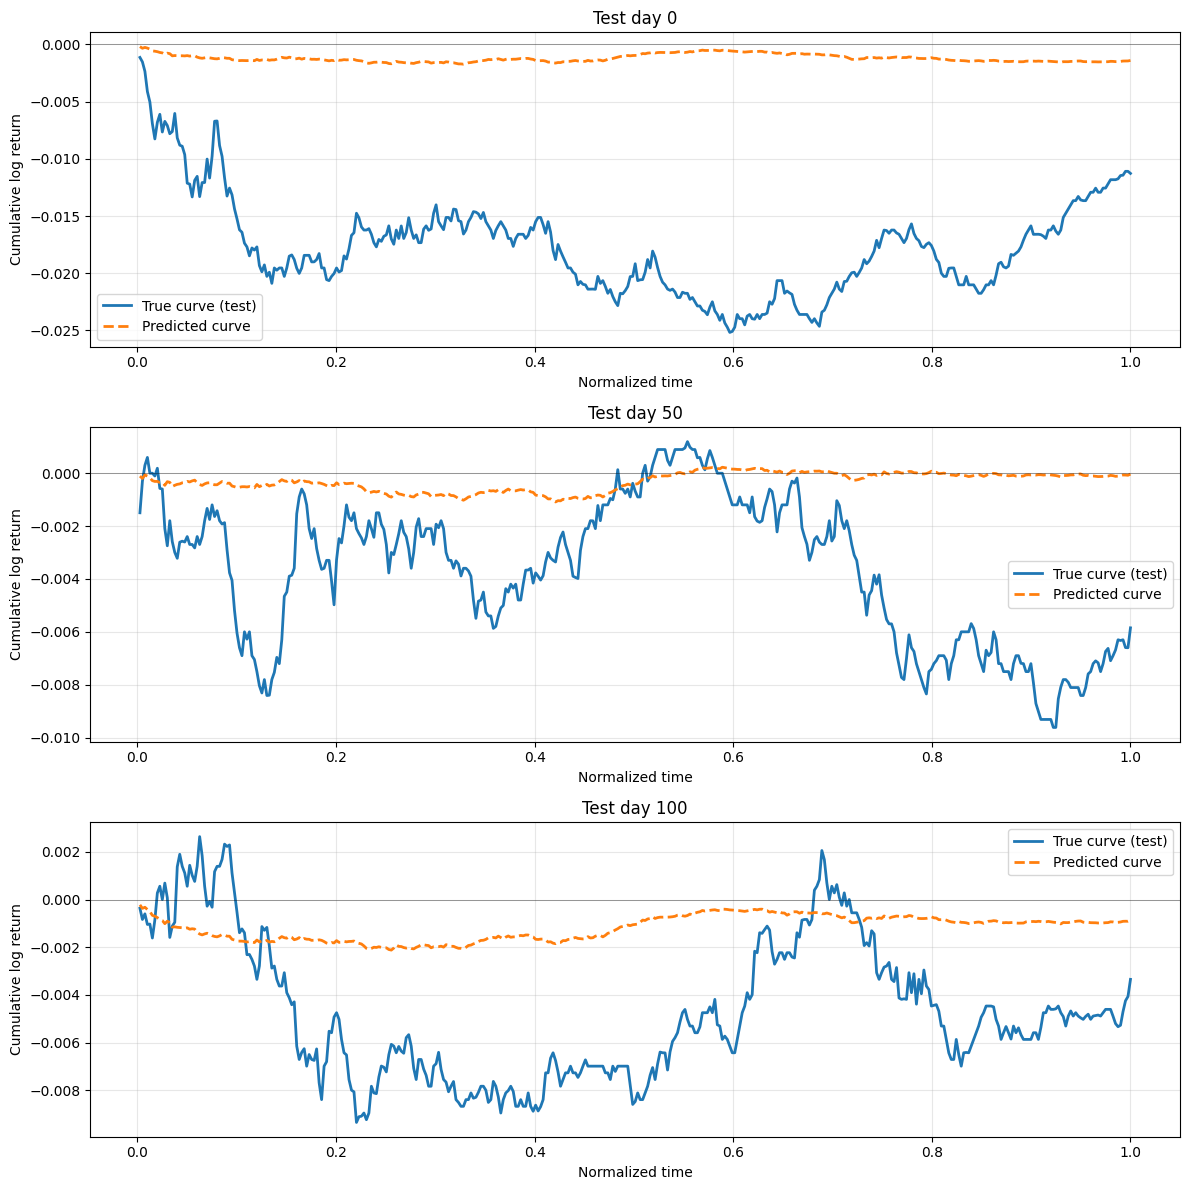

In [59]:
# Select a few test-day indices to display
idx_show = [0, 50, 100]
T_use = T[1:]   

plt.figure(figsize=(12, 4 * len(idx_show)))
for i, idx in enumerate(idx_show, 1):
    plt.subplot(len(idx_show), 1, i)
    plt.plot(T_use, M_test1[idx], label="True curve (test)", lw=2)
    plt.plot(T_use, Mhat_test[idx], label="Predicted curve", lw=2, linestyle="--")
    plt.axhline(0, color="k", lw=0.5, alpha=0.5)
    plt.title(f"Test day {idx}")
    plt.xlabel("Normalized time")
    plt.ylabel("Cumulative log return")
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
# plt.savefig("pred.png", dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# Baseline model = always predict 0
rmse_zero = np.sqrt(np.mean(M_test_use**2))

print("RMSE baseline (zero curve):", round(rmse_zero,7))
print("RMSE of the model (FPCA + VAR):", round(rmse_global,7))
print("Model / baseline ratio:", round(rmse_global/rmse_zero,7))

RMSE baseline (zero curve): 0.0109227
RMSE of the model (FPCA + VAR): 0.0109142
Model / baseline ratio: 0.9992247
